In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, normalize, LabelEncoder
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [2]:
df = pd.read_csv('../input/train.csv.gz')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.2+ MB


In [4]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Obviously the age of the animals should be importante, so we need to clean it up a bit.
From the frist lines we can see that the age is in the format Number<space>period. 

Lets see what periods are there.

In [5]:
df['AgeuponOutcome'].str.split(expand=True)[1].unique()

array(['year', 'years', 'weeks', 'month', 'months', 'days', 'week', 'day',
       None], dtype=object)

## So lets map each of these to a "multiplier", and calculate the age of the animals in days.

In [6]:
time_multiplier = dict(year = 365, years=365, weeks = 7, month = 30, months=30, days = 1, week = 7, day= 1)
foo = df['AgeuponOutcome'].str.split(expand=True)
age = foo[0].astype('float32')
period = foo[1]
del foo
period = period.map(time_multiplier)
df['age_in_days'] = age * period

In [7]:
print(df['SexuponOutcome'].str.split(expand=True)[0].unique())
print(df['SexuponOutcome'].str.split(expand=True)[1].unique())

['Neutered' 'Spayed' 'Intact' 'Unknown' nan]
['Male' 'Female' None]


In [8]:
foo = df['SexuponOutcome'].str.split(expand=True)
df['condition'] = foo[0].map({'Neutered': 'operated', 'Spayed':'operated', 'Intact': 'intact', 'Unknown': 'unknown'})
df['sex'] = foo[1]

Let's see some graphics to get the intuition on how the data is distributed

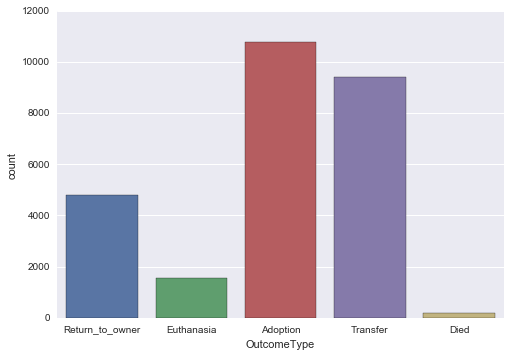

In [9]:
sns.countplot(x='OutcomeType', data=df)

So, it looks like most of the animals are being adopted or transfered. With some returning to their owner.
Only a small part of them are suffering euthanasia or dying (thanks god).

But how are these outcomes related to other characteristics of the animal? Are dogs and cats being are threated alike?

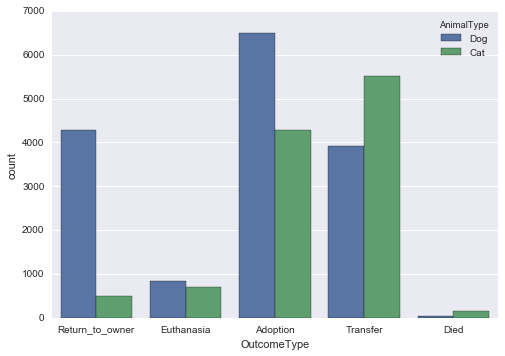

In [10]:
sns.countplot(x='OutcomeType', data=df, hue='AnimalType')

Dogs are prefered (as one would expect). The vast majority the animals returned to their owner are dogs. 
Dogs also haave a nice leading on adoption rate.

What about the sex?

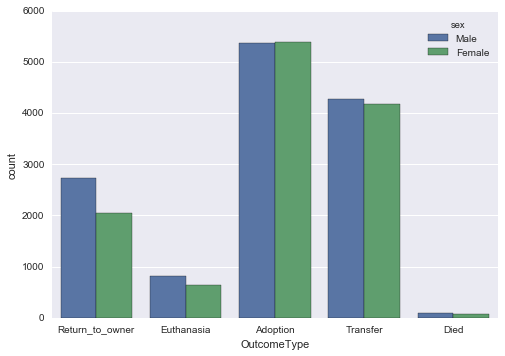

In [11]:
sns.countplot(x='OutcomeType', data=df, hue='sex')

So so... in general the sex of the animal doesn't appear to have much influence on their final destinty.

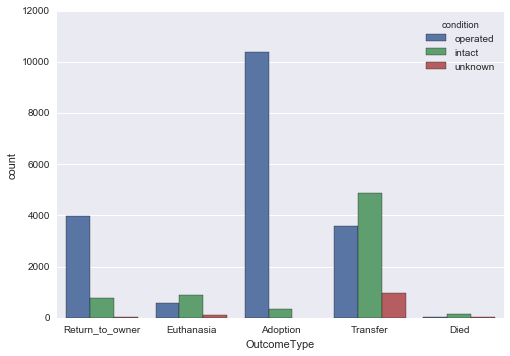

In [12]:
sns.countplot(x='OutcomeType', data=df, hue='condition')

Thats not the case when dealing on the codition of the animal. Most of the adopted or returned animals are operated.

Now lets see how the age influences this, for this we will use a boxplot.

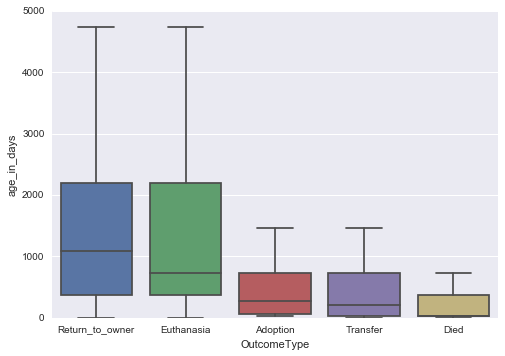

In [13]:
sns.boxplot(x='OutcomeType', y='age_in_days', data=df, showfliers=False) #showfliers=false disable the display of the outliers

Contrary to my initial expectations, young animals are the ones that day most, while old animmals return to their owner (the owner miss them?) or suffer from euthanasia (putting their out of their misery).

Adoptions are mainly about youg animals.

Lets see how the name of the animals influence their odds.

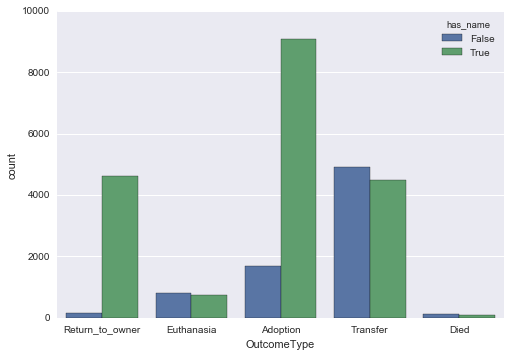

In [14]:
df['has_name'] = pd.notnull(df['Name'])
sns.countplot(x='OutcomeType', data=df, hue='has_name')

So, if the animal has a name people are more propensed to get them back or even adopt them (I get the case of return_to_owner, but... can't new owners give their pets a name?).

What about the color?

In [15]:
color_split = df.Color.str.split('/', expand=True)

df['color_1'] = color_split[0]
print(df.color_1.unique())
df['color_2'] = color_split[1]
print(df.color_2.unique())

['Brown' 'Cream Tabby' 'Blue' 'Blue Cream' 'Tan' 'Black' 'Blue Tabby'
 'Brown Tabby' 'Red' 'White' 'Silver' 'Orange Tabby' 'Brown Brindle'
 'Chocolate' 'Calico' 'Torbie' 'Yellow' 'Tricolor' 'Tortie' 'Gray' 'Buff'
 'Seal Point' 'Yellow Brindle' 'Fawn' 'Flame Point' 'Black Tabby'
 'Red Tick' 'Blue Merle' 'Sable' 'Brown Merle' 'Brown Tiger' 'Liver'
 'Cream' 'Blue Point' 'Apricot' 'Red Merle' 'Lynx Point' 'Lilac Point'
 'Tortie Point' 'Gray Tabby' 'Blue Tiger' 'Gold' 'Blue Tick' 'Black Smoke'
 'Calico Point' 'Black Brindle' 'Silver Tabby' 'Orange' 'Chocolate Point'
 'Agouti' 'Blue Smoke' 'Liver Tick' 'Pink' 'Silver Lynx Point' 'Ruddy'
 'Black Tiger' 'Orange Tiger']
['White' None 'Tan' 'Red' 'Cream' 'Brown' 'Black' 'Calico' 'Brown Brindle'
 'Gray' 'Silver' 'Cream Tabby' 'Blue Tabby' 'Brown Tabby' 'Red Tick' 'Blue'
 'Orange Tabby' 'Tricolor' 'Orange' 'Blue Tiger' 'Lynx Point' 'Buff'
 'Chocolate Point' 'Liver' 'Gold' 'Black Brindle' 'Blue Merle' 'Blue Tick'
 'Chocolate' 'Blue Cream' 'Black Ta

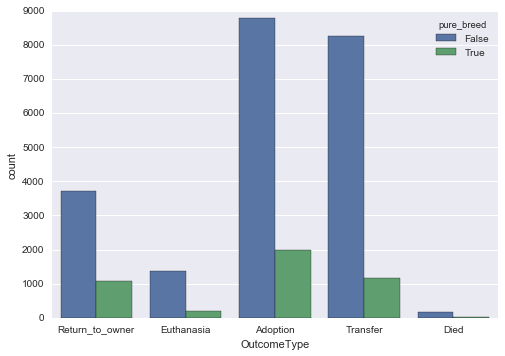

In [16]:
df['pure_breed'] = df.Breed.apply(lambda x : 'mix' not in x.lower())
sns.countplot(x='OutcomeType', data=df, hue='pure_breed')

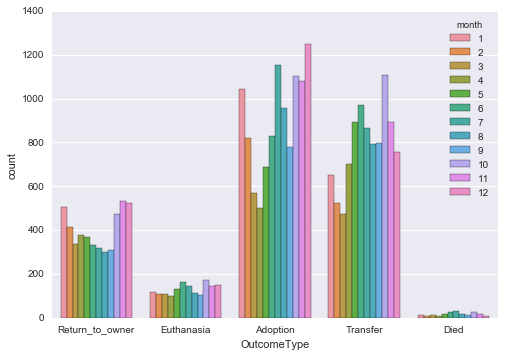

In [17]:
df.DateTime = pd.to_datetime(df.DateTime)
df['month'] = df.DateTime.dt.month.astype('category')
df['weekday'] = df.DateTime.dt.weekday.astype('category')
df['hour'] = df.DateTime.dt.hour.astype('category')
sns.countplot(x='OutcomeType', data=df, hue='month')

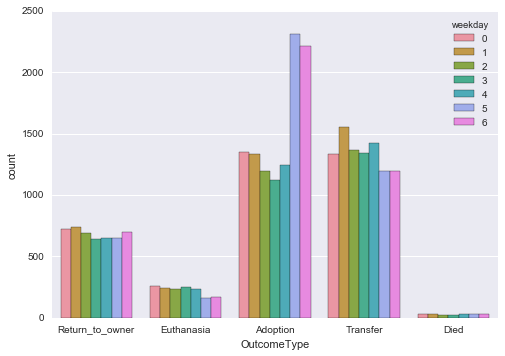

In [18]:
sns.countplot(x='OutcomeType', data=df, hue='weekday')

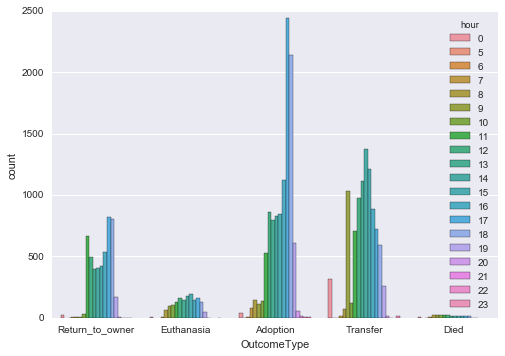

In [19]:
sns.countplot(x='OutcomeType', data=df, hue='hour')

In [20]:
print(df.Breed.value_counts()[:10])
print('---------')
print(df.Breed.str.replace(' Mix', '').value_counts()[:10])

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: Breed, dtype: int64
---------
Domestic Shorthair       8953
Pit Bull                 1972
Chihuahua Shorthair      1851
Labrador Retriever       1432
Domestic Medium Hair      881
German Shepherd           652
Domestic Longhair         543
Siamese                   413
Australian Cattle Dog     392
Dachshund                 364
Name: Breed, dtype: int64


In [21]:
print(len(df.Breed.value_counts()))
print(len(df.Breed.str.replace(' Mix', '').value_counts()))

1380
1244


In [22]:
df.Breed.value_counts()

Domestic Shorthair Mix                       8810
Pit Bull Mix                                 1906
Chihuahua Shorthair Mix                      1766
Labrador Retriever Mix                       1363
Domestic Medium Hair Mix                      839
German Shepherd Mix                           575
Domestic Longhair Mix                         520
Siamese Mix                                   389
Australian Cattle Dog Mix                     367
Dachshund Mix                                 318
Boxer Mix                                     245
Miniature Poodle Mix                          233
Border Collie Mix                             229
Australian Shepherd Mix                       163
Catahoula Mix                                 157
Rat Terrier Mix                               157
Jack Russell Terrier Mix                      146
Domestic Shorthair                            143
Yorkshire Terrier Mix                         143
Chihuahua Longhair Mix                        142


In [23]:
df['breed_rarity']=  pd.cut(df.Breed.value_counts(), 5, include_lowest=True, labels=['super rare', 'rare', 'comon', 'very comon', 'very very common' ])

In [24]:
y = df['OutcomeType']
x = df[['age_in_days','condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'breed_rarity', 'hour', 'weekday', 'month']]
x = pd.get_dummies(x)
x.info(null_counts=True, memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 155 columns):
age_in_days                      26711 non-null float64
has_name                         26729 non-null bool
pure_breed                       26729 non-null bool
condition_intact                 26729 non-null float64
condition_operated               26729 non-null float64
condition_unknown                26729 non-null float64
sex_Female                       26729 non-null float64
sex_Male                         26729 non-null float64
AnimalType_Cat                   26729 non-null float64
AnimalType_Dog                   26729 non-null float64
color_1_Agouti                   26729 non-null float64
color_1_Apricot                  26729 non-null float64
color_1_Black                    26729 non-null float64
color_1_Black Brindle            26729 non-null float64
color_1_Black Smoke              26729 non-null float64
color_1_Black Tabby              26729 non-null float64


Age in days has some null values. Lets fix it.

In [25]:
not_null = x.age_in_days.notnull()
x = x[not_null]
y = y[not_null]
col_names = x.columns
x = x.values
x.shape

(26711, 155)

In [26]:
rf = RandomForestClassifier()
rf.fit(x, y)

y_pred = rf.predict_proba(x)
print(log_loss(y, y_pred))

0.197866564763


In [27]:
print('Top features')
for score, feat in sorted(zip(rf.feature_importances_, col_names), reverse=True)[:10]:
    print('{:.3f} {}'.format(score,feat))
print()    
print('Botton features')
for score, feat in sorted(zip(rf.feature_importances_, col_names), reverse=True)[-10:]:
    print('{:.5f} {}'.format(score,feat))

Top features
0.173 age_in_days
0.066 condition_intact
0.045 condition_operated
0.043 has_name
0.027 color_2_White
0.021 color_1_Black
0.019 pure_breed
0.017 AnimalType_Dog
0.015 condition_unknown
0.015 month_12

Botton features
0.00000 color_2_Brown Tiger
0.00000 color_2_Flame Point
0.00000 color_2_Silver Tabby
0.00000 color_1_Ruddy
0.00000 color_1_Pink
0.00000 breed_rarity_very very common
0.00000 breed_rarity_very comon
0.00000 breed_rarity_super rare
0.00000 breed_rarity_rare
0.00000 breed_rarity_comon


So age in days is really important... What if we bin it?

Also breed_rarity didn't help a bit. So lets remove it.

In [28]:
df['age_bined']=  pd.cut(df.age_in_days, 10, include_lowest=True)

y = df['OutcomeType']
x = df[['age_bined','condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed','hour', 'weekday', 'month']]
x = pd.get_dummies(x)
#not_null = x.age_in_days.notnull()
#x = x[not_null]
#y = y[not_null]
col_names = x.columns
x = x.values
x.shape

(26729, 159)

In [29]:
rf = RandomForestClassifier(n_estimators=30, max_depth=None)
#svc = SVC(probability=True)
rf.fit(x, y)
#svc.fit(normalize(x), y)
print('forest')
y_pred = rf.predict_proba(x)
print(log_loss(y, y_pred))

forest
0.202286937139


In [30]:
print('Top features')
for score, feat in sorted(zip(rf.feature_importances_, col_names), reverse=True)[:10]:
    print('{:.3f} {}'.format(score,feat))
print()    
print('Botton features')
for score, feat in sorted(zip(rf.feature_importances_, col_names), reverse=True)[-10:]:
    print('{:.5f} {}'.format(score,feat))

Top features
0.085 condition_intact
0.053 condition_operated
0.044 has_name
0.032 color_2_White
0.029 age_bined_[-7.3, 730]
0.023 color_1_Black
0.021 pure_breed
0.018 sex_Male
0.017 month_12
0.017 sex_Female

Botton features
0.00002 color_2_Blue Tiger
0.00001 color_2_Brown Tiger
0.00001 hour_5
0.00001 color_2_Black Tabby
0.00001 color_1_Ruddy
0.00000 color_1_Silver Lynx Point
0.00000 color_2_Silver Tabby
0.00000 color_2_Chocolate Point
0.00000 color_1_Pink
0.00000 color_2_Flame Point


So... binning the age didn't help a bit... Lets keep the age_in_days.

We can try using the breed information to augment the dataset, but its too large (lots of different values).
We can use it, but first we have to reduce the number of feature (columns) using PCA.

In [31]:
breed = PCA(0.90).fit_transform(pd.get_dummies(df['Breed']))
print(breed.shape)

breed = pd.DataFrame(breed, columns=['breed_' + str(i) for i in range(breed.shape[1]) ])

(26729, 216)


In [71]:
y = df['OutcomeType'].values
y = LabelEncoder().fit_transform(y)

x = df[['age_in_days','condition', 'sex', 'AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed','hour', 'weekday', 'month']]
x = pd.concat((x, breed), axis=1)
x = pd.get_dummies(x)

not_null = x.age_in_days.notnull().values
x = x[not_null]
y = y[not_null]
col_names = x.columns
x = x.values
x.shape

(26711, 366)

In [33]:
rf = RandomForestClassifier(n_estimators=30, max_depth=None)
#svc = SVC(probability=True)
rf.fit(x, y)
#svc.fit(normalize(x), y)
print('forest')
y_pred = rf.predict_proba(x)
print(log_loss(y, y_pred))

forest
0.193378865132


In [34]:
print('Top features')
for score, feat in sorted(zip(rf.feature_importances_, col_names), reverse=True)[:10]:
    print('{:.3f} {}'.format(score,feat))
print()    
print('Botton features')
for score, feat in sorted(zip(rf.feature_importances_, col_names), reverse=True)[-10:]:
    print('{:.5f} {}'.format(score,feat))

Top features
0.126 age_in_days
0.059 condition_intact
0.053 condition_operated
0.041 has_name
0.021 color_2_White
0.017 color_1_Black
0.017 sex_Female
0.017 hour_17
0.017 sex_Male
0.016 hour_18

Botton features
0.00001 color_2_Blue Tiger
0.00001 color_2_Black Tabby
0.00001 color_1_Silver Lynx Point
0.00001 hour_5
0.00000 color_2_Brown Tiger
0.00000 color_2_Flame Point
0.00000 color_2_Chocolate Point
0.00000 color_1_Pink
0.00000 color_2_Silver Tabby
0.00000 color_1_Ruddy


While not among the top 10 features, obviously the breed of the animal helped (A LOT).

Lets see how our model behaves on unseen data. TO do it we will do crossvalidation

In [35]:
for train_indexes, test_indexes in StratifiedKFold(y, n_folds=5, random_state=42):     
    rfc = RandomForestClassifier()
    rfc.fit(x[train_indexes], y[train_indexes])
    pred = rfc.predict_proba(x[test_indexes])
    print(log_loss(y[test_indexes], pred))

2.70365085759
2.55757292624
2.51031458487
2.58416061939
2.7588281279


eek! This is bad!
The predictions are really BAD. But on the training set all was good...
This indicates a problem of overfitting: the model understands the training really well but can't generalize to unseen problems.

When dealing with trees one way to overcome this is to control the max_depth of the tree.
Lets see how this influences the predictions.

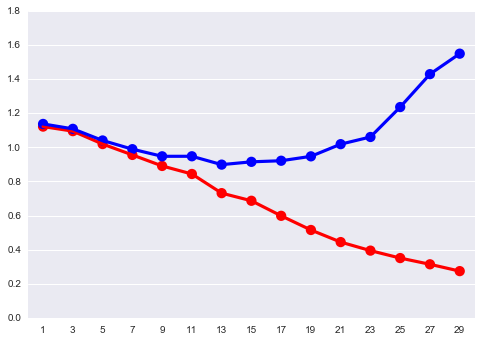

In [36]:
X_train, X_test, y_train,  y_test = train_test_split(x, y)
depth = list(range(1, 30, 2))
test_score = []
train_score = []
for d in depth:
    rfc = RandomForestClassifier(max_depth=d)
    rfc.fit(X_train, y_train)
    train_score.append(log_loss(y_train, rfc.predict_proba(X_train)))
    test_score.append(log_loss(y_test, rfc.predict_proba(X_test)))

ax = sns.pointplot(depth, train_score, color='red')
ax = sns.pointplot(depth, test_score, color='blue')

Thats the problem! The depth plays an important role here. Until depth is 9-10 all is good and is helps lower the training scores (a bit), but when we go above 13 the test results start increasing REALLY fast. So lets keep the depth at check with a value of 10.

As our data is also very unbalanced (very few animals die), we might take a look at the min_samples_leaf variable on RandomForests as well (this contrl how many itens must be at the leaf).

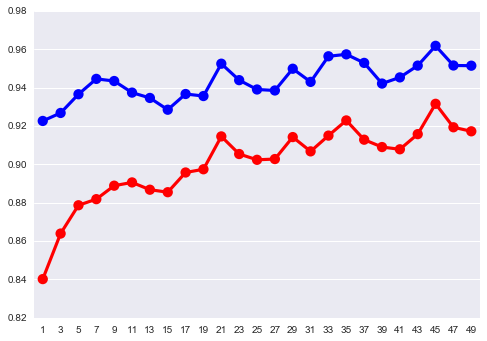

In [37]:
min_samples_leaf = list(range(1, 50, 2))
test_score = []
train_score = []
for m in min_samples_leaf:
    rfc = RandomForestClassifier(max_depth=10, min_samples_leaf= m, random_state=42)
    rfc.fit(X_train, y_train)
    train_score.append(log_loss(y_train, rfc.predict_proba(X_train)))
    test_score.append(log_loss(y_test, rfc.predict_proba(X_test)))

ax = sns.pointplot(min_samples_leaf, train_score, color='red')
ax = sns.pointplot(min_samples_leaf, test_score, color='blue')

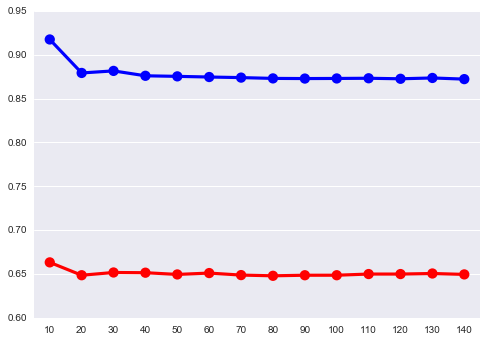

In [38]:
estimators = list(range(10, 150, 10))
test_score = []
train_score = []
for e in estimators:
    rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=1, random_state=42, n_estimators=e)
    rfc.fit(X_train, y_train)
    train_score.append(log_loss(y_train, rfc.predict_proba(X_train)))
    test_score.append(log_loss(y_test, rfc.predict_proba(X_test)))

ax = sns.pointplot(estimators, train_score, color='red')
ax = sns.pointplot(estimators, test_score, color='blue')

So, above 40 trees we don't see much improvement?
But maybe, now that we have more trees some of the other parameters can be changed.
While we could go back and check max_depth and min_samples_leaf with the new values there is a better way: grid search with cross validation.

In [39]:
rfc_params = {
    'n_estimators' : np.linspace(10,60, 3, dtype='int'),
    'max_depth': np.linspace(2, 30, 3, dtype='int'),
    'criterion' : ['gini', 'entropy'],
    'min_samples_leaf': np.linspace(1, 15, 3, dtype='int'),    
}
grid = GridSearchCV(RandomForestClassifier(), rfc_params, n_jobs=1, verbose=3, scoring='log_loss')
grid.fit(x, y)
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] min_samples_leaf=1, criterion=gini, n_estimators=10, max_depth=2 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=10, max_depth=2, score=-1.108169 -   1.3s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=10, max_depth=2 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=10, max_depth=2, score=-1.129494 -   1.2s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=10, max_depth=2 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=10, max_depth=2, score=-1.124054 -   1.3s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=2 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=2, score=-1.097054 -   1.7s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=2 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=2, score=-1.116791 -   1.7s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=2 
[CV]  min_samples_leaf=1, c

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  1.0min


[CV]  min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=16, score=-0.860515 -   3.7s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=16 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=35, max_depth=16, score=-0.860169 -   3.6s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=60, max_depth=16 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=60, max_depth=16, score=-0.859537 -   5.2s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=60, max_depth=16 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=60, max_depth=16, score=-0.859968 -   5.5s
[CV] min_samples_leaf=1, criterion=gini, n_estimators=60, max_depth=16 
[CV]  min_samples_leaf=1, criterion=gini, n_estimators=60, max_depth=16, score=-0.858231 -   5.4s
[CV] min_samples_leaf=8, criterion=gini, n_estimators=10, max_depth=16 
[CV]  min_samples_leaf=8, criterion=gini, n_estimators=10, max_depth=16, score=-0.916497 -   1.6s
[CV] min_samples_leaf=8, criterion=gini, n_estimator

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  5.8min


[CV]  min_samples_leaf=15, criterion=entropy, n_estimators=10, max_depth=16, score=-0.934789 -   1.5s
[CV] min_samples_leaf=15, criterion=entropy, n_estimators=10, max_depth=16 
[CV]  min_samples_leaf=15, criterion=entropy, n_estimators=10, max_depth=16, score=-0.915217 -   1.4s
[CV] min_samples_leaf=15, criterion=entropy, n_estimators=35, max_depth=16 
[CV]  min_samples_leaf=15, criterion=entropy, n_estimators=35, max_depth=16, score=-0.926111 -   2.6s
[CV] min_samples_leaf=15, criterion=entropy, n_estimators=35, max_depth=16 
[CV]  min_samples_leaf=15, criterion=entropy, n_estimators=35, max_depth=16, score=-0.926460 -   2.8s
[CV] min_samples_leaf=15, criterion=entropy, n_estimators=35, max_depth=16 
[CV]  min_samples_leaf=15, criterion=entropy, n_estimators=35, max_depth=16, score=-0.927557 -   2.7s
[CV] min_samples_leaf=15, criterion=entropy, n_estimators=60, max_depth=16 
[CV]  min_samples_leaf=15, criterion=entropy, n_estimators=60, max_depth=16, score=-0.921497 -   3.8s
[CV] min

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  7.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 1,  8, 15]), 'criterion': ['gini', 'entropy'], 'n_estimators': array([10, 35, 60]), 'max_depth': array([ 2, 16, 30])},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=3)

In [91]:
x_normal = normalize(x).astype('float32')
print(x.shape)
svc_params = {
    'loss' : ['log'],
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'alpha' : np.logspace(-5, -3, 5),
    'n_iter': np.linspace(5, 20, 5, dtype='int'),
}
grid = GridSearchCV(SGDClassifier(), svc_params, n_jobs=1, verbose=3, scoring='log_loss')
grid.fit(x_normal, y)
print(grid.best_score_)
print(grid.best_params_)

C:\Users\ur57\AppData\Local\Continuum\Anaconda3-64\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


(26711, 366)
Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] penalty=l1, n_iter=5, loss=log, alpha=1e-05 .....................
[CV]  penalty=l1, n_iter=5, loss=log, alpha=1e-05, score=-1.264525 -   1.3s
[CV] penalty=l1, n_iter=5, loss=log, alpha=1e-05 .....................
[CV]  penalty=l1, n_iter=5, loss=log, alpha=1e-05, score=-1.312590 -   1.4s
[CV] penalty=l1, n_iter=5, loss=log, alpha=1e-05 .....................
[CV]  penalty=l1, n_iter=5, loss=log, alpha=1e-05, score=-1.156135 -   1.3s
[CV] penalty=l2, n_iter=5, loss=log, alpha=1e-05 .....................
[CV]  penalty=l2, n_iter=5, loss=log, alpha=1e-05, score=-1.053201 -   0.6s
[CV] penalty=l2, n_iter=5, loss=log, alpha=1e-05 .....................
[CV]  penalty=l2, n_iter=5, loss=log, alpha=1e-05, score=-1.101594 -   0.6s
[CV] penalty=l2, n_iter=5, loss=log, alpha=1e-05 .....................
[CV]  penalty=l2, n_iter=5, loss=log, alpha=1e-05, score=-1.257736 -   0.6s
[CV] penalty=elasticnet, n_iter=5, loss=log

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  1.1min


[CV]  penalty=l2, n_iter=16, loss=log, alpha=1e-05, score=-1.078566 -   1.7s
[CV] penalty=l2, n_iter=16, loss=log, alpha=1e-05 ....................
[CV]  penalty=l2, n_iter=16, loss=log, alpha=1e-05, score=-1.104823 -   1.8s
[CV] penalty=elasticnet, n_iter=16, loss=log, alpha=1e-05 ............
[CV]  penalty=elasticnet, n_iter=16, loss=log, alpha=1e-05, score=-1.075738 -   4.6s
[CV] penalty=elasticnet, n_iter=16, loss=log, alpha=1e-05 ............
[CV]  penalty=elasticnet, n_iter=16, loss=log, alpha=1e-05, score=-1.053031 -   4.6s
[CV] penalty=elasticnet, n_iter=16, loss=log, alpha=1e-05 ............
[CV]  penalty=elasticnet, n_iter=16, loss=log, alpha=1e-05, score=-1.099213 -   4.6s
[CV] penalty=l1, n_iter=20, loss=log, alpha=1e-05 ....................
[CV]  penalty=l1, n_iter=20, loss=log, alpha=1e-05, score=-0.990947 -   4.9s
[CV] penalty=l1, n_iter=20, loss=log, alpha=1e-05 ....................
[CV]  penalty=l1, n_iter=20, loss=log, alpha=1e-05, score=-1.002838 -   5.0s
[CV] penalt

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  5.6min


[CV]  penalty=l1, n_iter=20, loss=log, alpha=0.0001, score=-1.071228 -   5.0s
[CV] penalty=l1, n_iter=20, loss=log, alpha=0.0001 ...................
[CV]  penalty=l1, n_iter=20, loss=log, alpha=0.0001, score=-1.066107 -   5.0s
[CV] penalty=l2, n_iter=20, loss=log, alpha=0.0001 ...................
[CV]  penalty=l2, n_iter=20, loss=log, alpha=0.0001, score=-1.153133 -   2.2s
[CV] penalty=l2, n_iter=20, loss=log, alpha=0.0001 ...................
[CV]  penalty=l2, n_iter=20, loss=log, alpha=0.0001, score=-1.152218 -   2.2s
[CV] penalty=l2, n_iter=20, loss=log, alpha=0.0001 ...................
[CV]  penalty=l2, n_iter=20, loss=log, alpha=0.0001, score=-1.154403 -   2.2s
[CV] penalty=elasticnet, n_iter=20, loss=log, alpha=0.0001 ...........
[CV]  penalty=elasticnet, n_iter=20, loss=log, alpha=0.0001, score=-1.150811 -   5.5s
[CV] penalty=elasticnet, n_iter=20, loss=log, alpha=0.0001 ...........
[CV]  penalty=elasticnet, n_iter=20, loss=log, alpha=0.0001, score=-1.150920 -   5.5s
[CV] penalty

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 10.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-05,   3.16228e-05,   1.00000e-04,   3.16228e-04,
         1.00000e-03]), 'n_iter': array([ 5,  8, 12, 16, 20]), 'loss': ['log'], 'penalty': ['l1', 'l2', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=3)

In [110]:
gbc_params = {
    'learning_rate' : [0.1], # np.linspace(0.1, 0.5, 3),
    'n_estimators' : np.linspace(30, 100, 3, dtype='int'),
    'subsample' : np.linspace(0.5, 0.85, 3),
}
grid = GridSearchCV(GradientBoostingClassifier(verbose=2), gbc_params, n_jobs=1, verbose=3, scoring='log_loss')
grid.fit(x_normal, y)
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.1, subsample=0.5, n_estimators=30 ...............
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       12303.5982        1032.0768           41.93s
         2       11494.0528         770.2955           39.51s
         3       10833.8631         597.8982           37.93s
         4       10375.0015         489.0096           36.37s
         5       10002.5877         397.9485           35.09s
         6        9600.4536         336.7061           33.58s
         7        9327.4111         281.4463           32.21s
         8        9063.5225         230.3087           30.90s
         9        8916.4251         206.3400           29.49s
        10        8675.4118         162.8558           28.08s
        11        8581.0596         144.2359           26.65s
        12        8398.2825         123.2542           25.25s
        13        8252.2047         105.2300           23.91s


KeyboardInterrupt: 